In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [17]:
from core.img_patch_stats_analysis_lib import *

### MNIST

In [2]:
!echo $STORE_DIR/Datasets

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets


In [3]:
import torchvision
import torchvision.transforms as transforms
# load MNIST dataset, make it a B x 28 x 28 tensor
mnist_dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                                           train=True, download=True, transform=transforms.ToTensor())
mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
print(mnist_Xtsr.shape) # 60000 x 28 x 28

torch.Size([60000, 1, 28, 28])


In [6]:
savedir = f"{saveroot}/MNIST_MLP_EDM_width1024_small_lr_long_train"
os.makedirs(savedir, exist_ok=True)

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          #   "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "X_mean": X_mean.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [7]:
record_step_list = [*range(0, 10, 1), *range(10, 50, 2), *range(50, 100, 4), *range(100, 500, 8), *range(500, 2500, 16), 
                    *range(2500, 5000, 32), *range(5000, 10000, 64), *range(10000, 20000, 128), *range(20000, 50000, 256), *range(50000, 100000, 512)]

MNIST dataset 60000 samples, 784 features


  0%|          | 0/100000 [00:00<?, ?it/s]

step 0 loss 2.743


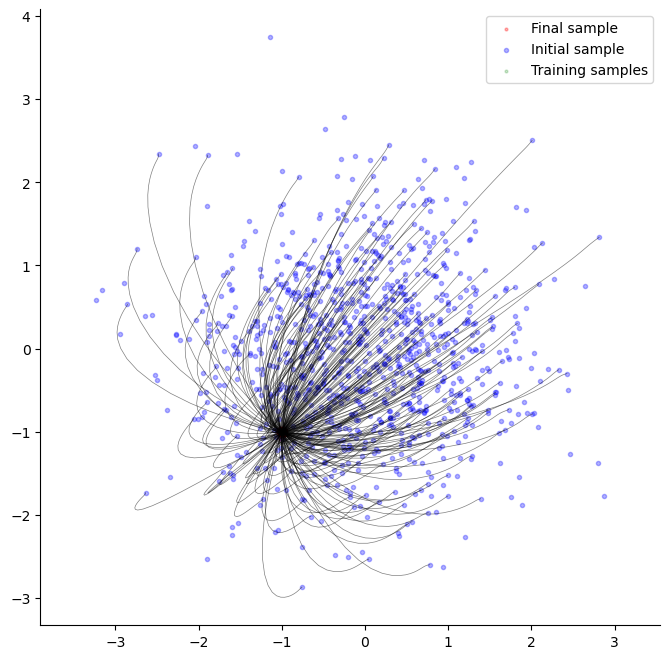

In [8]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=8, nhidden=1024, time_embed_dim=128,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=100000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

In [9]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [ ]:
step_slice = sorted([*sample_store.keys()])

In [19]:

def process_pnts_mean_cov_statistics(train_pnts, sample_store, savedir, device="cuda",):
    train_X_mean = train_pnts.mean(dim=0)
    train_X_cov = torch.cov(train_pnts.T)
    train_X_eigval, train_X_eigvec = torch.linalg.eigh(train_X_cov.to(device))
    train_X_eigval = train_X_eigval.flip(0)
    train_X_eigvec = train_X_eigvec.flip(1)
    train_X_eigvec = train_X_eigvec.to(device)
    print(f"train_X_eigval.shape: {train_X_eigval.shape} computed on {train_pnts.shape[0]} samples")
    mean_x_sample_traj = []
    cov_x_sample_traj = []
    diag_cov_x_sample_true_eigenbasis_traj = []
    step_slice = sorted([*sample_store.keys()])
    for training_step in tqdm(step_slice):
        x_final = sample_store[training_step]
        if isinstance(x_final, tuple):
            x_final = x_final[0]
        x_final_patches = x_final.view(x_final.shape[0], -1)
        mean_x_sample = x_final_patches.mean(dim=0)
        cov_x_sample = torch.cov(x_final_patches.to(device).T)
        mean_x_sample_traj.append(mean_x_sample.cpu())
        # Estimate the variance along the eigenvector of the covariance matrix
        cov_x_sample_true_eigenbasis = train_X_eigvec.T @ cov_x_sample.to(device) @ train_X_eigvec
        diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
        diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
        cov_x_sample_traj.append(cov_x_sample.cpu())
    
    mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
    cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
    diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

    pkl.dump({
        "diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj, 
        "mean_x_sample_traj": mean_x_sample_traj,
        "cov_x_sample_traj": cov_x_sample_traj,
        "train_X_mean": train_X_mean.cpu(),
        "train_X_cov": train_X_cov.cpu(),
        "train_X_eigval": train_X_eigval.cpu(),
        "train_X_eigvec": train_X_eigvec.cpu(),
        "step_slice": step_slice
    }, open(f"{savedir}/sample_pnts_cov_true_eigenbasis_diag_traj.pkl", "wb"))
    print(f"Saved to {savedir}/sample_pnts_cov_true_eigenbasis_diag_traj.pkl")
    return train_X_mean, train_X_cov, train_X_eigval, train_X_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj

In [10]:
from circuit_toolkit.plot_utils import to_imgrid

In [15]:
# visualize samples 
step_samples = [1, 10, 50, 100, 500, 5000, 10000, 20000, 50000, 100000]
x_final_list = []
for step in step_samples:
    x_final, = sample_store[step]
    x_final_img = ((x_final[3].view(28, 28) + 1) / 2).clamp(0, 1)
    x_final_list.append(x_final_img)
    # plt.imshow(x_final_img.cpu().numpy(), cmap="gray")
    # plt.show()
to_imgrid(torch.stack(x_final_list).unsqueeze(1), nrow=10, padding=1)


In [20]:
train_X_mean, train_X_cov, train_X_eigval, train_X_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
    process_pnts_mean_cov_statistics(pnts, sample_store, savedir, device="cuda")

train_X_eigval.shape: torch.Size([784]) computed on 60000 samples


  0%|          | 0/671 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM_width1024_small_lr_long_train/sample_pnts_cov_true_eigenbasis_diag_traj.pkl


In [21]:
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)

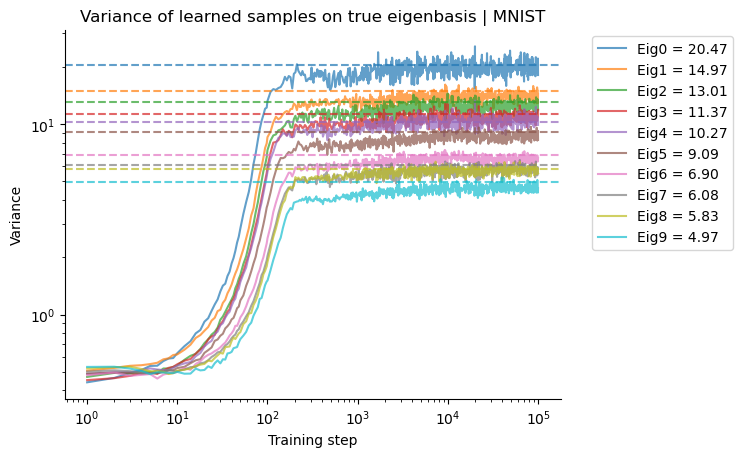

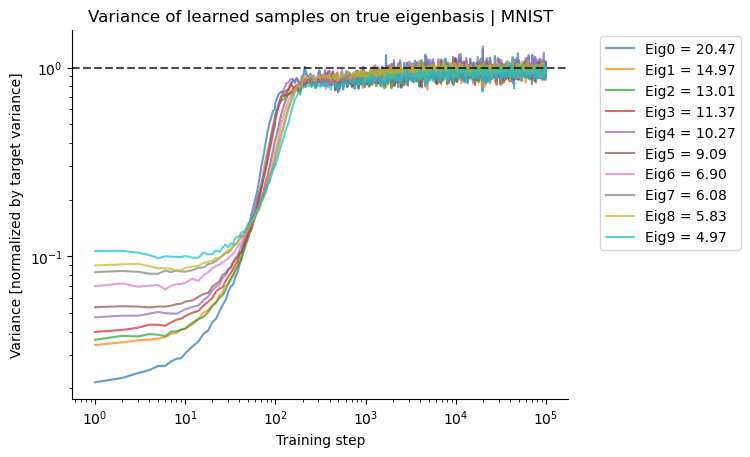

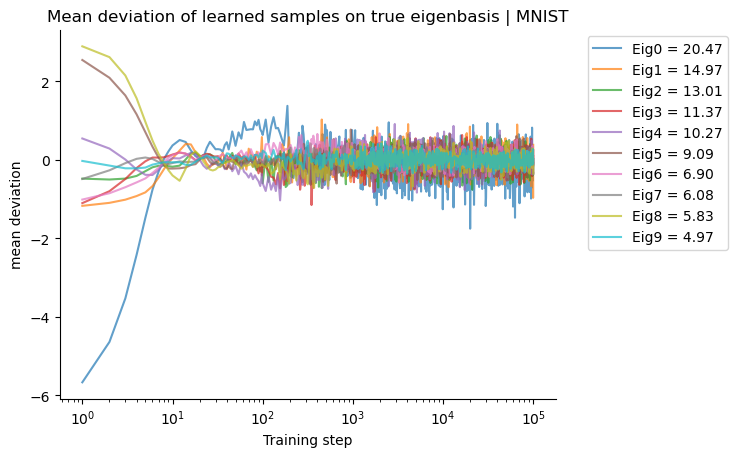

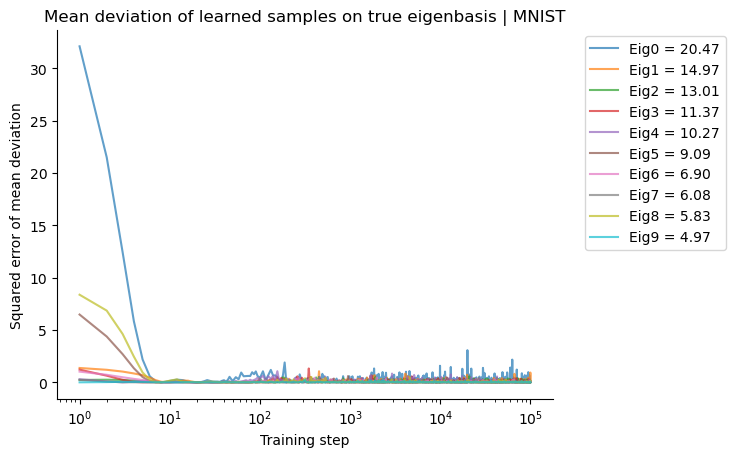

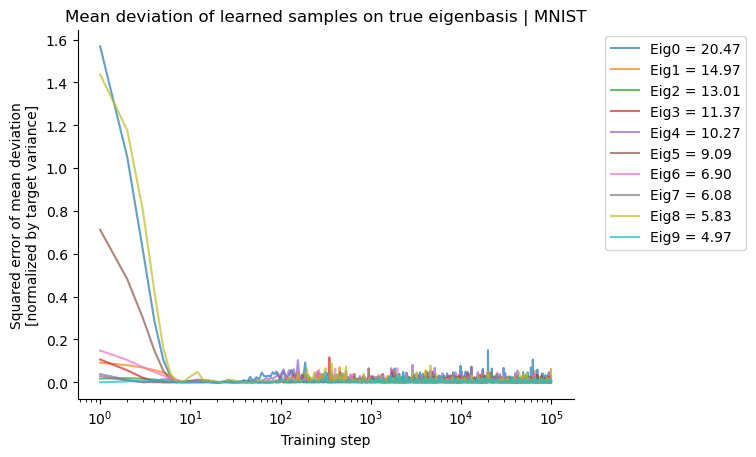

In [23]:
step_slice = sorted([*sample_store.keys()])
slice2plot = slice(None, 10, 1)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")

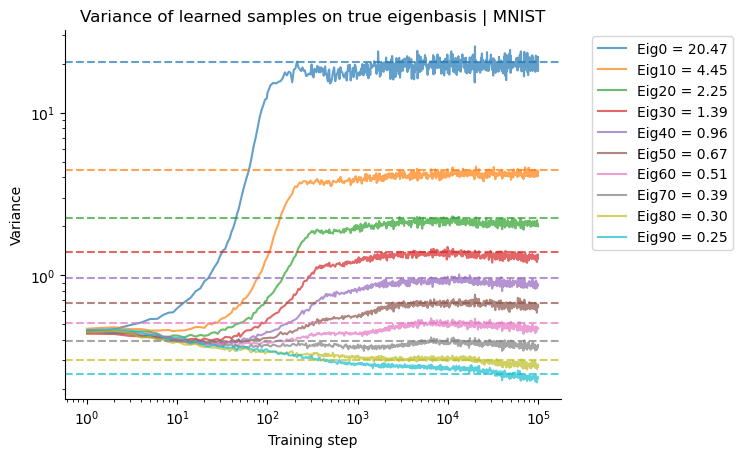

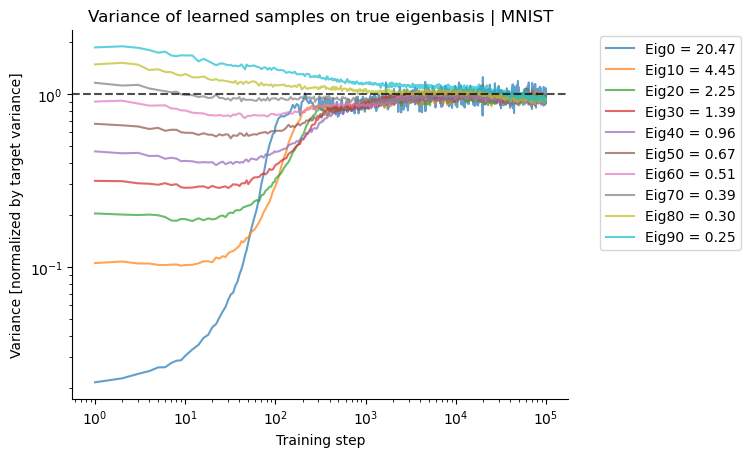

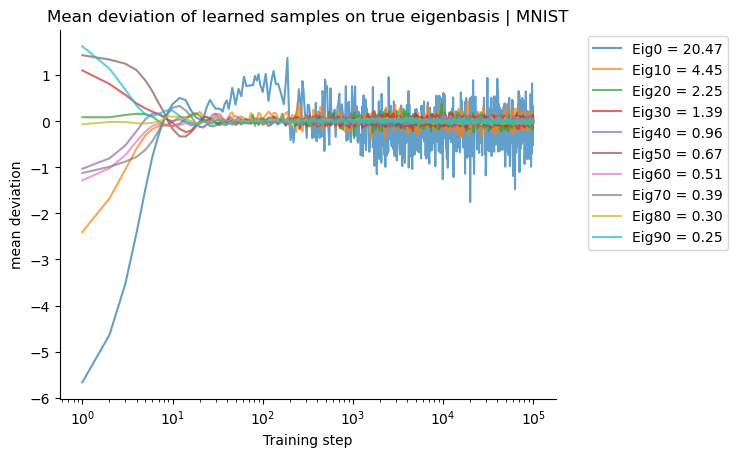

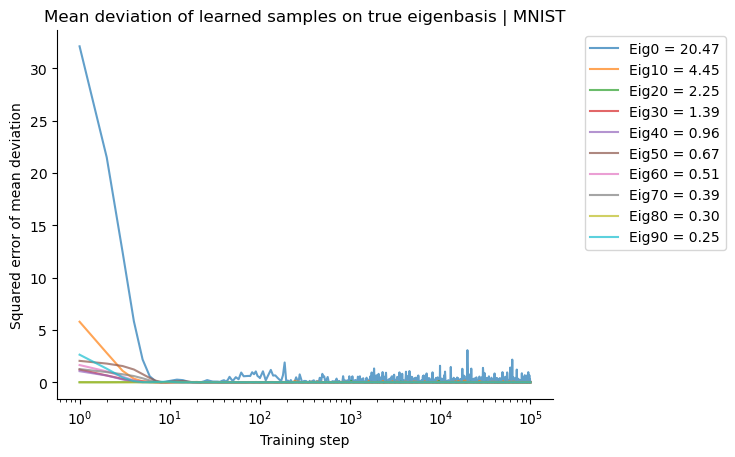

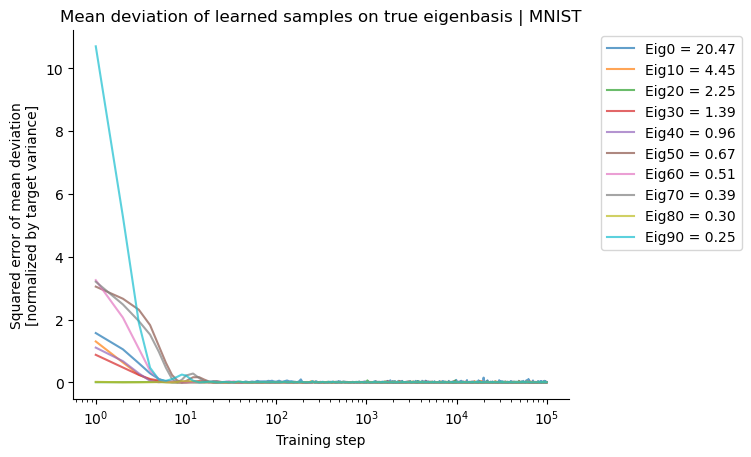

In [24]:
slice2plot = slice(None, 100, 10)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")

In [25]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM_width1024_small_lr_long_train/figures'

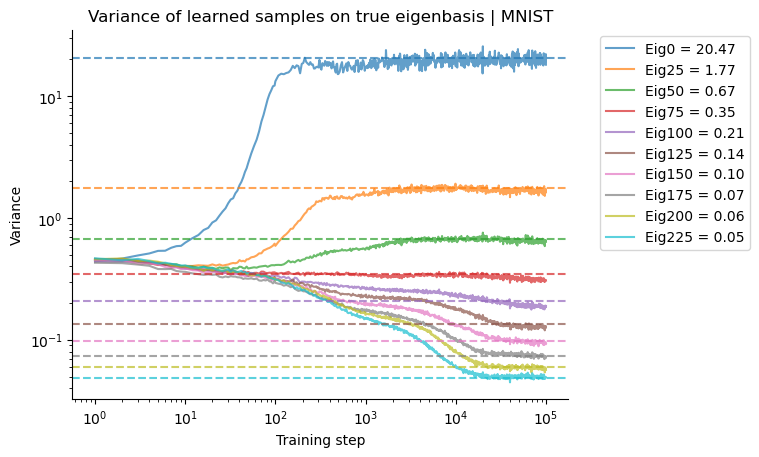

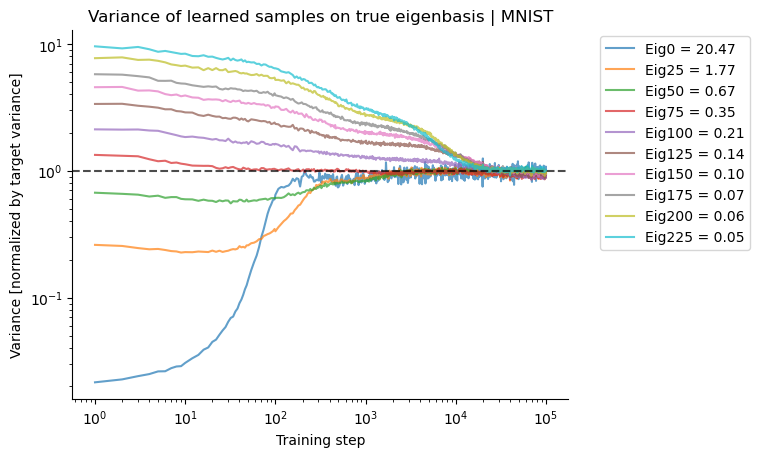

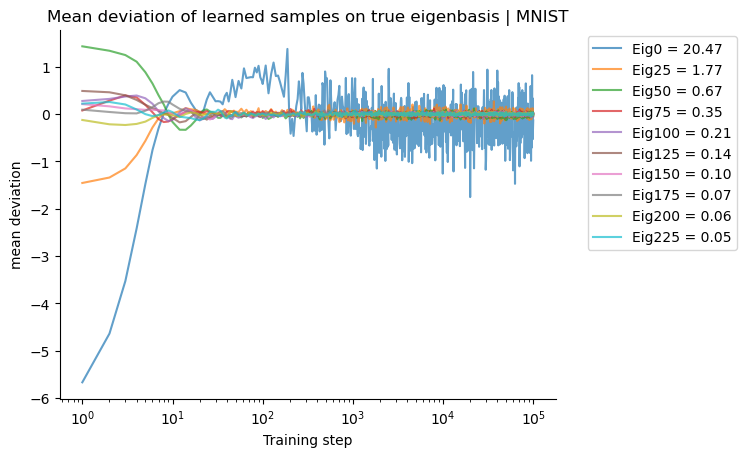

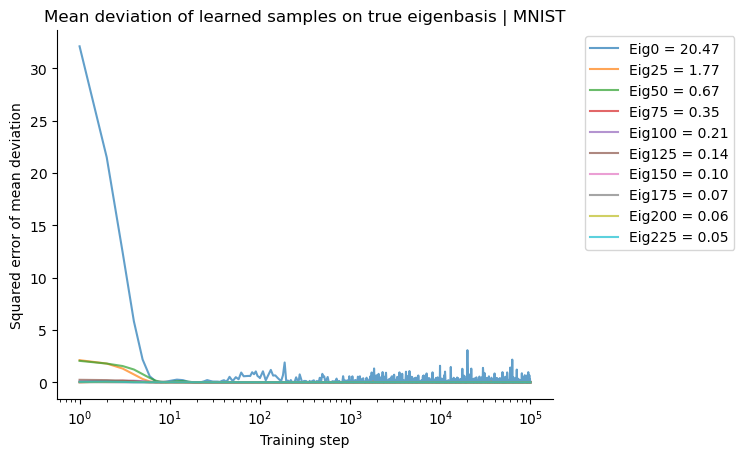

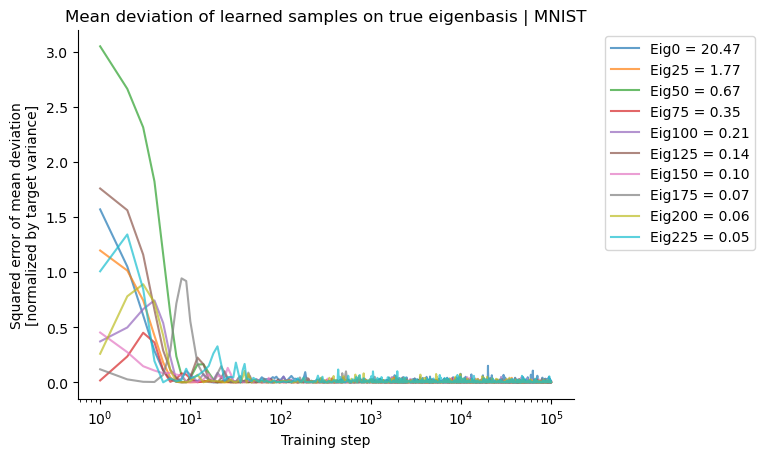

In [26]:
slice2plot = slice(None, 250, 25)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")

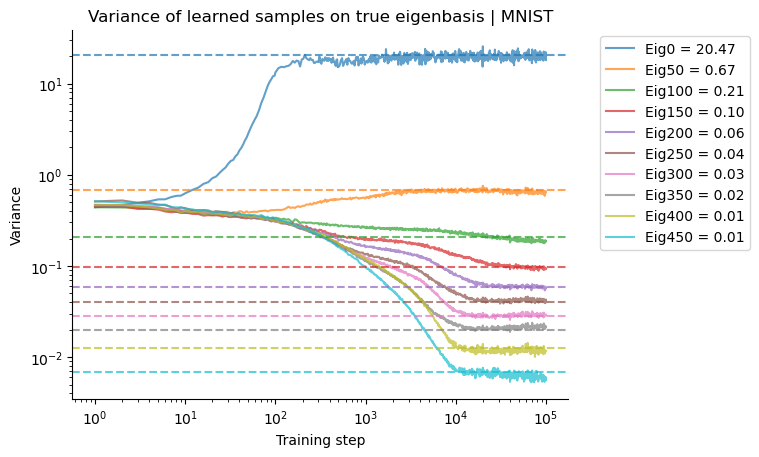

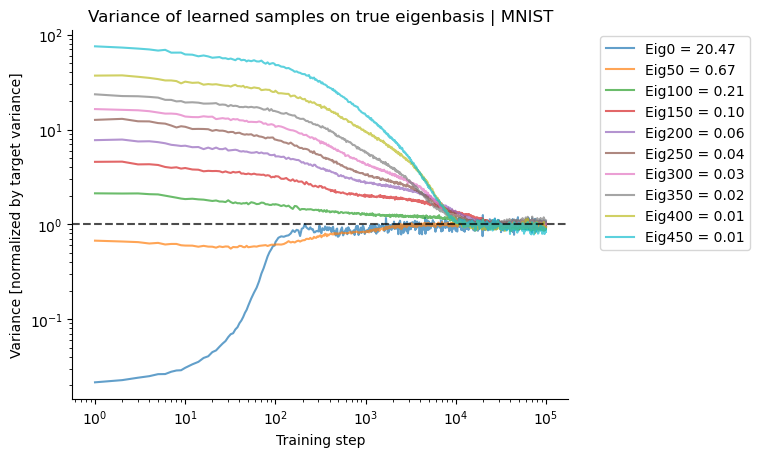

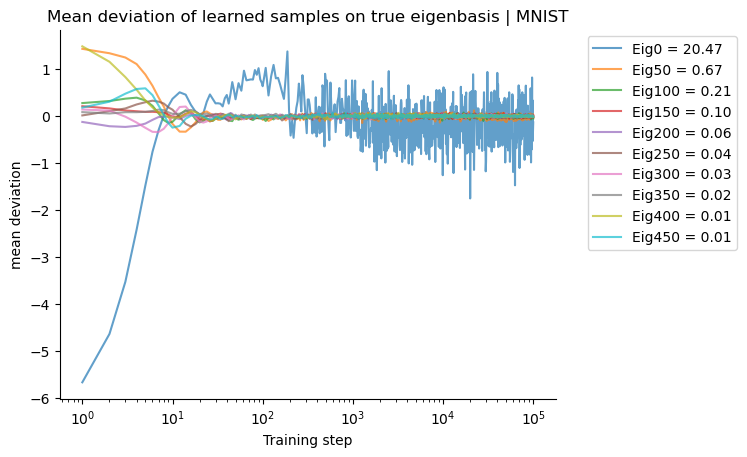

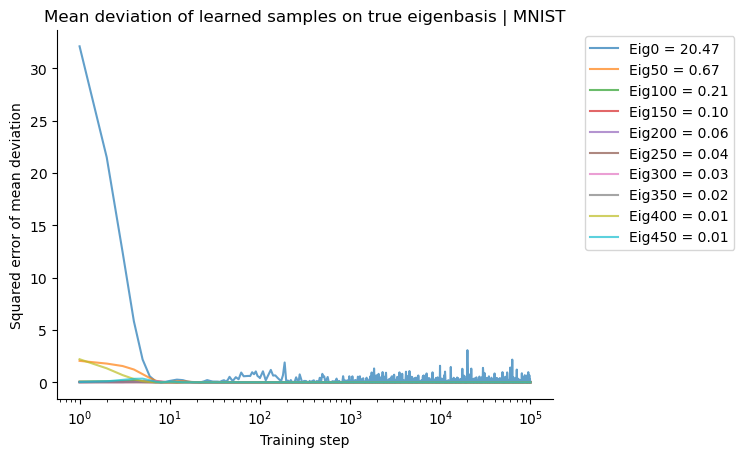

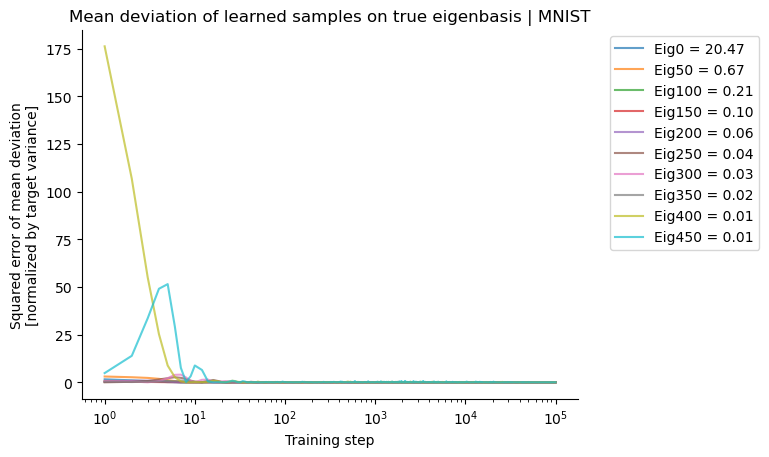

In [27]:
slice2plot = slice(None, 500, 50)
plot_sample_pnts_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj, train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")
plot_sample_pnts_mean_deviation_trajectories(step_slice, mean_x_sample_traj, train_X_mean.cpu(), train_X_eigvec.cpu(), train_X_eigval.cpu(), slice2plot, figdir, dataset_name="MNIST")

#### synopsis

In [28]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=False):
    if isinstance(trajectory, torch.Tensor):
        trajectory = trajectory.cpu().numpy()
    if isinstance(threshold, torch.Tensor):
        threshold = threshold.cpu().numpy()
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=2)
    # determine the direction of the crossing
    direction = 1 if smoothed_trajectory[0] > threshold else -1
    if direction == 1:
        crossing_indices = np.where(smoothed_trajectory < threshold)[0]
    else:
        crossing_indices = np.where(smoothed_trajectory > threshold)[0]
    if len(crossing_indices) > 0:
        return crossing_indices[0] if first_crossing else crossing_indices[-1], direction
    else:
        return None, direction


def harmonic_mean(A, B):
    return 2 / (1 / A + 1 / B)

In [29]:
step_slice = sorted([*sample_store.keys()])
num_trajectories = diag_cov_x_sample_true_eigenbasis_traj.shape[1]
crossing_steps = []
directions = []
for i in range(num_trajectories):
    trajectory = diag_cov_x_sample_true_eigenbasis_traj[:, i]
    threshold = harmonic_mean(train_X_eigval[i], trajectory[0])
    crossing_idx, direction = smooth_and_find_threshold_crossing(trajectory, threshold, first_crossing=True)
    if crossing_idx is not None:
        crossing_steps.append(step_slice[crossing_idx])
        directions.append(direction)
    else:
        print(f"No crossing found for mode {i}")
        crossing_steps.append(np.nan)
        directions.append(0)

No crossing found for mode 64
No crossing found for mode 630
No crossing found for mode 631
No crossing found for mode 632
No crossing found for mode 633
No crossing found for mode 634
No crossing found for mode 635
No crossing found for mode 636
No crossing found for mode 637
No crossing found for mode 638
No crossing found for mode 639
No crossing found for mode 640
No crossing found for mode 641
No crossing found for mode 642
No crossing found for mode 643
No crossing found for mode 644
No crossing found for mode 645
No crossing found for mode 646
No crossing found for mode 647
No crossing found for mode 648
No crossing found for mode 649
No crossing found for mode 650
No crossing found for mode 651
No crossing found for mode 652
No crossing found for mode 653
No crossing found for mode 654
No crossing found for mode 655
No crossing found for mode 656
No crossing found for mode 657
No crossing found for mode 658
No crossing found for mode 659
No crossing found for mode 660
No crossi

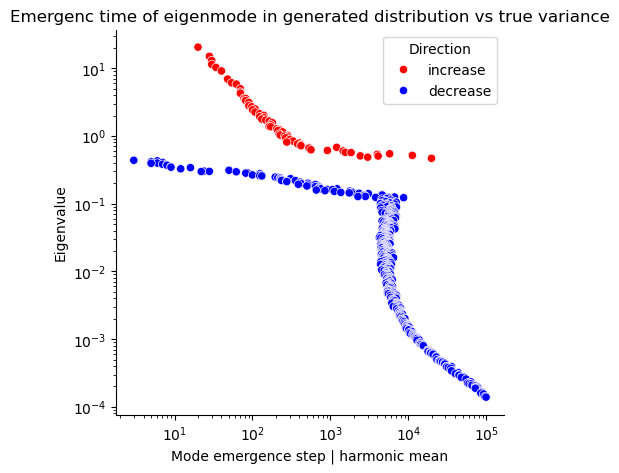

In [30]:
# make a dataframe
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"Variance": train_X_eigval.cpu().numpy(), "emergence_step": crossing_steps, "direction": directions})
# translate direction 1 -> decrease, -1 -> increase
df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
# df.to_csv(f"{savedir}/crossing_points.csv", index=False)
figh = plt.figure(figsize=[5, 5])
# Decide which direction maps to which color
palette = {"decrease": "blue", "increase": "red"}
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", 
                palette=palette,)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title("Emergenc time of eigenmode in generated distribution vs true variance")
saveallforms(savedir, "synopsis_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()
df.to_csv(f"{savedir}/synopsis_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)

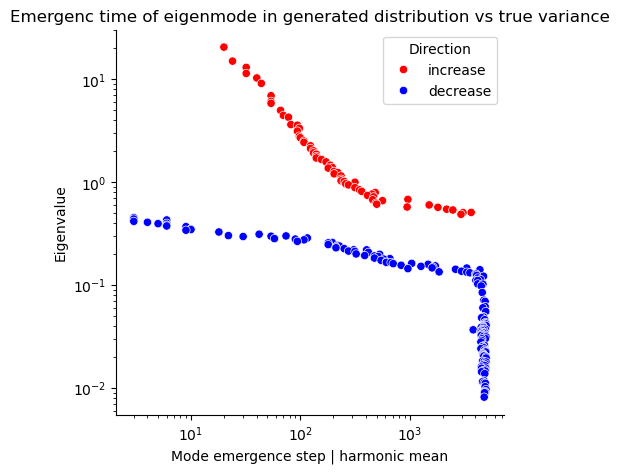

In [ ]:
# make a dataframe
import pandas as pd
import seaborn as sns
df = pd.DataFrame({"Variance": train_X_eigval.cpu().numpy(), "emergence_step": crossing_steps, "direction": directions})
# translate direction 1 -> decrease, -1 -> increase
df["Direction"] = df["direction"].map({1: "decrease", -1: "increase"})
# df.to_csv(f"{savedir}/crossing_points.csv", index=False)
figh = plt.figure(figsize=[5, 5])
# Decide which direction maps to which color
palette = {"decrease": "blue", "increase": "red"}
sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", 
                palette=palette,)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title("Emergenc time of eigenmode in generated distribution vs true variance")
saveallforms(savedir, "synopsis_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()
df.to_csv(f"{savedir}/synopsis_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)

In [ ]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/1001 [00:00<?, ?it/s]

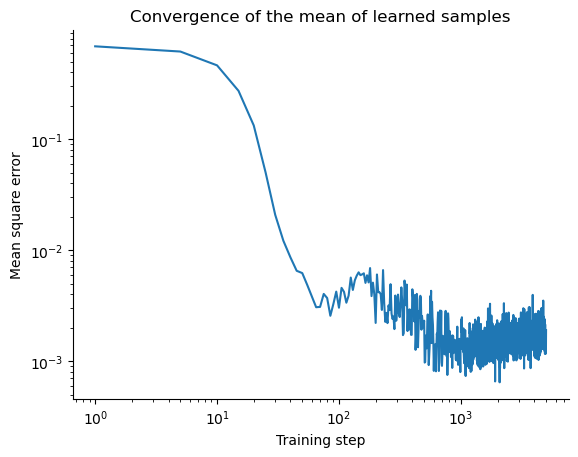

In [ ]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.cuda() - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

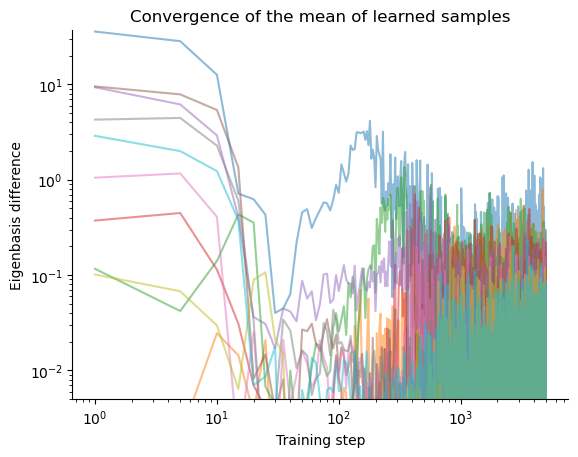

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
plt.plot(step_slice, mean_X_diff_true_basis.pow(2).cpu().numpy()[:, slice(None, 20, 2)], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

In [ ]:
mean_X_diff_true_basis.shape

torch.Size([1001, 784])

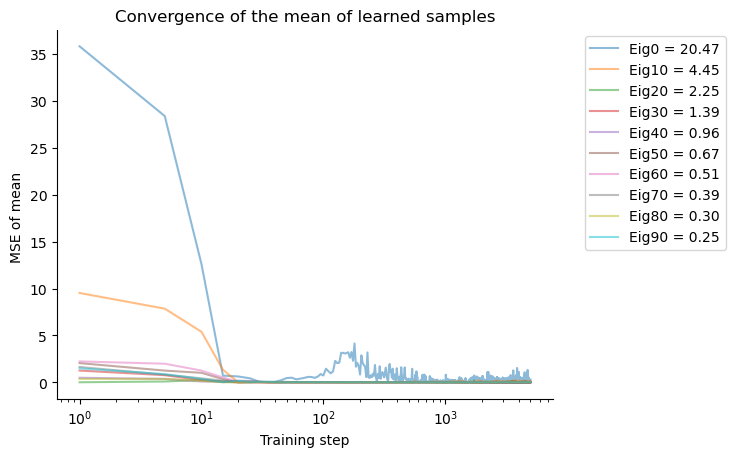

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

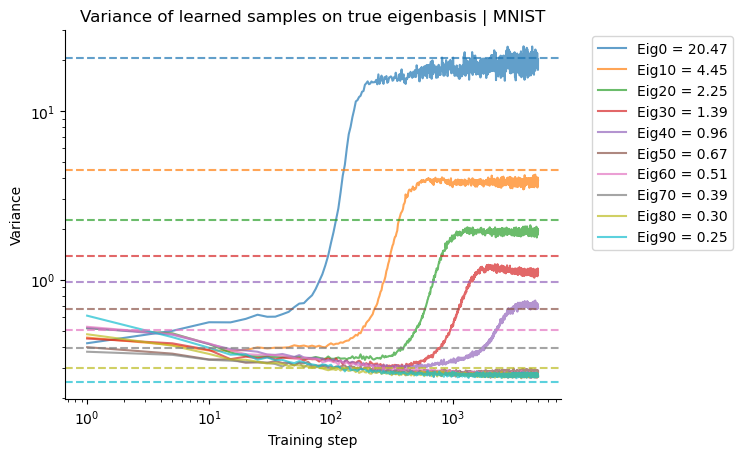

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

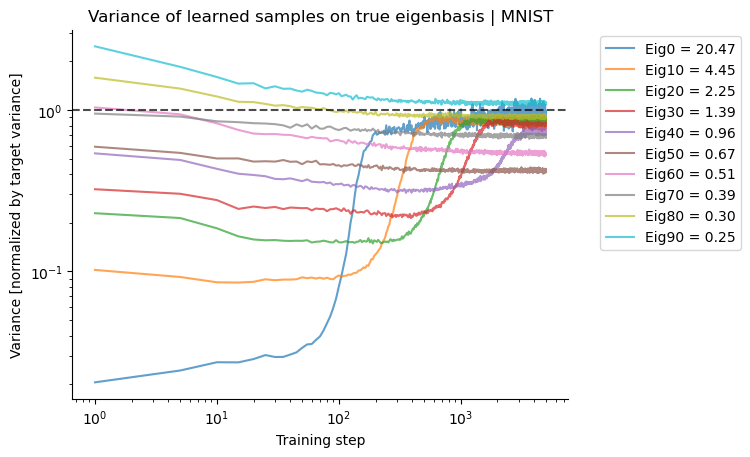

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()